# Relative PDE measurement & Analysis with continuous light

This notebook shows how to use **IV** and **reverse_iv** calasses to analize the IV curves and calculate relative PDE

The absolute *PDE* measurements method requires a pulsed light source, as LEDs or a laser, so it is possible only for a limited number of wavelengths. Therefore, to measure the $PDE$ in a wide wavelength range, from 260 nm up to 1150 nm, a  so called *Relative PDE*, is used. Here is set-up schematics:

![Schematic layouts of the developed experimental set-up for relative PDE measurements](./images/ContiniousSchematic.png)

Where a 75 W Xenon lamp is used as light source and it is coupled to a mono-chromator is to select the wavelengths in a short range. The reverse current-voltage IV characteristics of the SiPM device at different wavelengths are performed using a Keithley 2400, while a Keithley 6487 is used to read photocurrent from calibrated photodiode.

The measuremts were done with <a href="https://manualzz.com/doc/7246422/tls-series---newport-corporation">TLS_75X Xenon lamp</a> . By changing the slit width, one can change **wavelength resolution** and adapt **light intensity**:
![Monochromator resolution vs. Slit width](./images/lamp_rresolution.png)

Typicaly, the slit of 0.05 and 0.120 used for wavelenth range from to 300 (some times 350nm) to 1200 nm. While the slits of 0.28 - 0.78 to wavelength of 250 - 300 nm 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from IPython.display import Image

from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from scipy.interpolate import interp1d
from IV import IV
from reverse_iv import relative_pde

# Play with IV data:

To do a basic analisis with IV (forward or Reverse) **IV** class was developed. In this section we will show how to use it 

### Data format: 

At each wavelength, we measure reverse IV. So at a given Voltage (Voltage(V)) we measure current (Current(A)). In paralele, we measure the photocurrent from Photodiode (DiodeCurrent(A)) and its standard deviation (DiodeCurrent Std(A)). Therefore, at each wavelength we have a txt file with a structure:

In [2]:
dark_iv_file = './data_example/LCT5_NUV_3075CN/SN_1/0.05/Hamamatsu_LCT5_NUVWL_dark_nm.txt'
!head -n 7 $dark_iv_file

### Lets read and display reverse IV for dark and 400nm: 

lets read **dark** (*'Hamamatsu_LCT5_NUVWL_1dark_nm.txt'*) and **400nm** (*'Hamamatsu_LCT5_NUVWL_400_nm.txt'*) data.

In [3]:
sipm_dark_iv = IV('./data_example/LCT5_NUV_3075CN/SN_1/0.05/Hamamatsu_LCT5_NUVWL_dark_nm.txt')
sipm_400nm_iv = IV('./data_example/LCT5_NUV_3075CN/SN_1/0.05/Hamamatsu_LCT5_NUVWL_400_nm.txt')
sipm_dark_iv.read_IV_file()
sipm_400nm_iv.read_IV_file()

now, lets plot reverse IVs:

no interpolation were done
no interpolation were done


(50.0, 60.0)

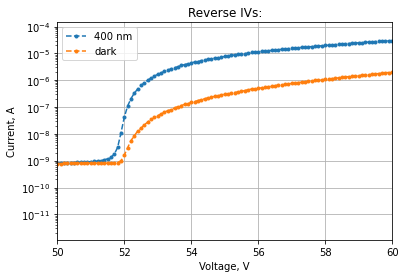

In [4]:
fig, ax = plt.subplots()

sipm_400nm_iv.draw_iv(ax, plot_label = '400 nm')
sipm_dark_iv.draw_iv(ax, plot_label = 'dark')
ax.set_title('Reverse IVs:')
ax.set_xlim(50, 60)

## Calculate relative PDE:

First, we should define the path to folder, which containes IV measuremetns at different wavenths. One txt file for each wavelngth (structure was described above). **Important:** folder should contain one file with dark measurements. Dark measuremts, marked at file name with name **"dark"**, for example: 'Hamamatsu_LCT5_NUVWL_1dark_nm.txt'

Lets define the path to such folder:

In [5]:
data_folder = './data_example/LCT5_NUV_3075CN/SN_1/0.05/'

lets see the first 10 files in the folder:

In [6]:
!ls $data_folder | head -10

Hamamatsu_LCT5_NUVWL_1000_nm.txt
Hamamatsu_LCT5_NUVWL_270_nm.txt
Hamamatsu_LCT5_NUVWL_280_nm.txt
Hamamatsu_LCT5_NUVWL_290_nm.txt
Hamamatsu_LCT5_NUVWL_300_nm.txt
Hamamatsu_LCT5_NUVWL_310_nm.txt
Hamamatsu_LCT5_NUVWL_320_nm.txt
Hamamatsu_LCT5_NUVWL_330_nm.txt
Hamamatsu_LCT5_NUVWL_340_nm.txt
Hamamatsu_LCT5_NUVWL_350_nm.txt


Lets create an object of class **relative_pde**:

In [7]:
iv_data_50um = relative_pde(data_folder, wl_err = 0.7)

**The relative PDE, may be calculated as:**

$$
  PDE_{rel} = \frac{1}{R} \times \frac{I_{SiPM}}{I_{PD}} \times QE_{PD}
$$

where:
* $R$  - is the power ratio, $R = P_{PD}/P_{SiPM}$, between the light intensity measured by the calibrated photodiode, $P_{PD}$, and the SiPM, $P_{SiPM}$, is measured experimentally, by replasing the SiPM with another calibrated photodiode;
* $I_{SiPM}$ - is the SiPM photocurent (after dark current subtraction) at a give bias voltage $V_{bias}$;
* $I_{PD}$ - is the Photodiode photocurent (after dark current subtraction)
* $QE_{PD}$ - is the Photodiode quantume efficency

$R$ can be calculated from file "ratio_0.600_long.txt", where at each wavelength the values from two photodidead at STD were saved:

In [8]:
file_with_2pd = './data_example/LCT5_NUV_3075CN/ratio_0.600_long.txt'
!head -n 4 $file_with_2pd

lets read such file:

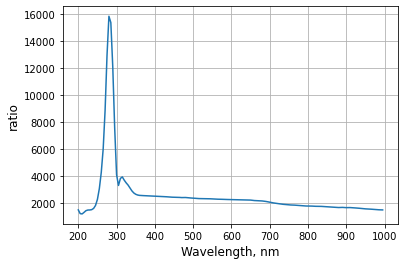

In [9]:
iv_data_50um.read_ratio_file(file_with_2pd)

wl = np.arange(200, 1000, 5)
plt.plot(wl, iv_data_50um.f_ratio(wl))
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("ratio", fontsize=12)
plt.grid()

The $QE_{PD}$ is provided by producer and located at:

In [10]:
qe_data = 'PD_S1337-1010BQ_SN01.out'

Lets plot QE for our device:

Text(0, 0.5, 'Photodiode QE, %')

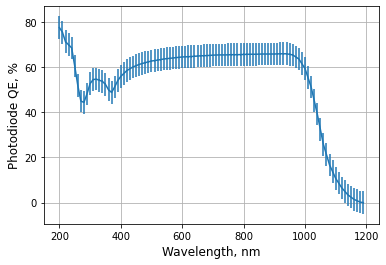

In [11]:
iv_data_50um.get_qe(qe_data)

plt.errorbar(iv_data_50um.wl_qe, iv_data_50um.qe, yerr = iv_data_50um.qe_err, xerr = iv_data_50um.wl_err)
plt.grid()
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Photodiode QE, %", fontsize=12)

PDE is a function of Overvoltage $\Delta$V ($\Delta$V = $V_{Bias}$ - $V_{BD}$) . Fits, we should define an overvoltage at which analyse data:

In [12]:
overvoltage = 6

Lets, calculate relative PDE:

1000
wl =  1000  nm.
V BD =  51.934765083861606
270
wl =  270  nm.
V BD =  51.87869336612399
280
wl =  280  nm.
V BD =  51.89344484924765
290
wl =  290  nm.
V BD =  51.88361037941922
300
wl =  300  nm.
V BD =  51.850601095227674
310
wl =  310  nm.
V BD =  51.85316538329519
320
wl =  320  nm.
V BD =  51.845491316810815
330
wl =  330  nm.
V BD =  51.84780939307069
340
wl =  340  nm.
V BD =  51.84290172510818
350
wl =  350  nm.
V BD =  51.8266321560641
360
wl =  360  nm.
V BD =  51.81485558876488
370
wl =  370  nm.
V BD =  51.81334288891367
380
wl =  380  nm.
V BD =  51.803822616621304
390
wl =  390  nm.
V BD =  51.81933219025123
400
wl =  400  nm.
V BD =  51.809190287401215
410
wl =  410  nm.
V BD =  51.79649552890959
420
wl =  420  nm.
V BD =  51.825641600901086
430
wl =  430  nm.
V BD =  51.80334401528587
440
wl =  440  nm.
V BD =  51.807217228813734
450
wl =  450  nm.
V BD =  51.79385824034561
460
wl =  460  nm.
V BD =  51.777010007228206
470
wl =  470  nm.
V BD =  51.83449852422321
4

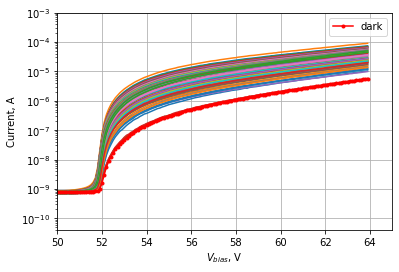

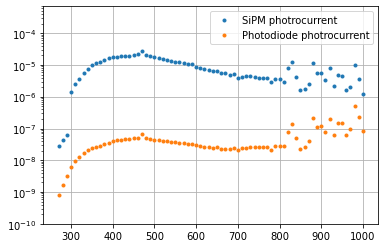

In [13]:
iv_data_50um = relative_pde(data_folder, wl_err = 0.7)
iv_data_50um.calc_relative_pde(file_with_2pd, qe_data, dV=overvoltage, Vbd = np.NaN, debug=True)

where:
* file_with_2pd - file with current from two photodiodes;
* qe_data - file with Photodiode QE;
* dV - Overvoltage;
* Vbd - breakdown voltage, if Vbd == np.NaN the Vbd will be calculated for each IV from inverse second derivative method
* debug - show intermediate results or not

lets plot SiPM photocurent (after dark current subtraction) as a function of wavelength:

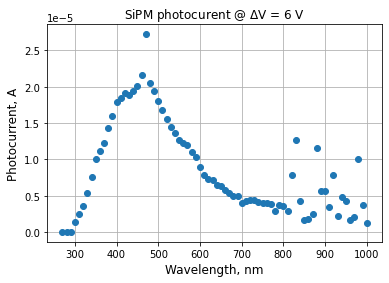

In [14]:
plt.plot(list(iv_data_50um.sipm_photocurent.keys()), list(iv_data_50um.sipm_photocurent.values()), 'o')
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Photocurrent, A", fontsize=12)
plt.title('SiPM photocurent @ $\Delta$V = {:} V'.format(overvoltage))
plt.grid()

lets plot Photodiode photocurent (after dark current subtraction) as a function of wavelength

In [15]:
plt.plot(list(iv_data_50um.photodiode_photocurent.keys()), list(iv_data_50um.photodiode_photocurent.values()), 'o')
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Photocurrent, A", fontsize=12)
plt.grid()

Breakdown voltage distribution:

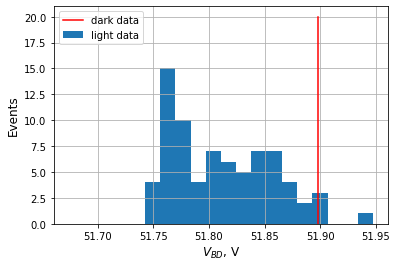

In [16]:
vbd_mean = np.mean(list(iv_data_50um.vbd_dict.values()))
vbd_std = np.std(list(iv_data_50um.vbd_dict.values()))

plt.hist(list(iv_data_50um.vbd_dict.values()), range = [vbd_mean - 3*vbd_std, vbd_mean + 3*vbd_std], bins = 20, label = 'light data')
plt.xlabel("$V_{BD}$, V", fontsize=12)
plt.ylabel("Events", fontsize=12)
plt.plot([iv_data_50um.vbd_dict['dark'], iv_data_50um.vbd_dict['dark']], [0, 20], 'r', label = 'dark data')
plt.grid()
plt.legend()

Breakdown vs. wavelength:

In [17]:
x_wavelength = []
y_vbd = []

vbd_1000nm = np.NaN

for key in iv_data_50um.vbd_dict.keys():
    
    if key == 'dark':
        vbd_dark = iv_data_50um.vbd_dict['dark']
    else:
        x_wavelength.append(float(key))
        y_vbd.append(iv_data_50um.vbd_dict[key])
    
    if key == 1000:
        vbd_1000nm = iv_data_50um.vbd_dict[key]
        x_wavelength.remove(float(key))
        y_vbd.remove(iv_data_50um.vbd_dict[key])
        
if vbd_1000nm != np.NaN:
    x_wavelength.append(1000)
    y_vbd.append(vbd_1000nm)

In [18]:
plt.plot(x_wavelength, y_vbd, 'o-')
plt.plot([x_wavelength[0], x_wavelength[-1]], [vbd_dark, vbd_dark], 'r-', label = 'dark')
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("$V_{BD}$ V", fontsize=12)
plt.grid()

Change of breakdown with wavelength indicates some T change over the measuremetns, but nothing crytical since analysis is corrected to breakdown voltage change

If we know the Vbd temperature coeeficient (for LCT5 is ~ 54mV/C) we can calculate the T change during the measuremtns:

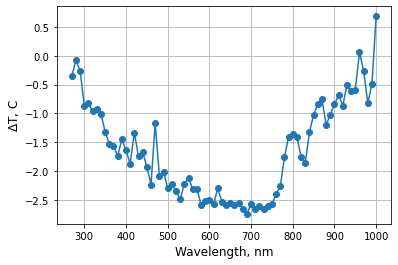

In [19]:
Tcoeff = 0.054 # V/C for Hamamatsu LCT5 devices
plt.plot(x_wavelength, (np.array(y_vbd)-vbd_dark)/Tcoeff, 'o-')
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("$\Delta$T, C", fontsize=12)
plt.grid()

### Plot relative PDE: 

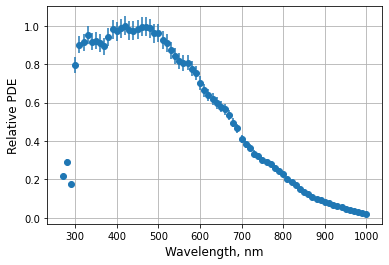

In [20]:
plt.errorbar(iv_data_50um.pde_relative.keys(), list(iv_data_50um.pde_relative.values()), fmt = 'o', yerr = list(iv_data_50um.pde_relative_err.values()), xerr = iv_data_50um.wl_err)
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Relative PDE", fontsize=12)
plt.grid()

### PDE analysis at slit width = 1200 um:

Sometimes, to measure PDE at short wavelengthes (i.e 200 - 300nm), the slit width sould be increased to increase the light intensity. However, such measuremtnts, should not be done for all wavelength range (200 - 1000nm), becaseu due to high light intensity, the SiPM may be satureted. Lets see the analysis for measurements done with 1200 um slit width:

In [21]:
folder_1200um_path='./data_example/LCT5_NUV_3075CN/SN_1/0.120_short/'

In [22]:
iv_data_1200um = relative_pde(folder_1200um_path, wl_err = 3.7)
iv_data_1200um.calc_relative_pde(file_with_2pd, qe_data, dV=overvoltage, Vbd = np.NaN, debug=False)

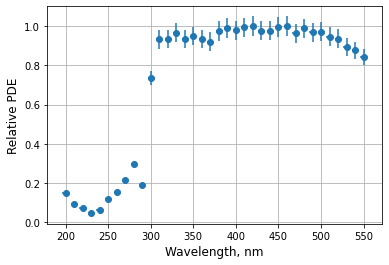

In [23]:
plt.errorbar(iv_data_1200um.pde_relative.keys(), list(iv_data_1200um.pde_relative.values()), fmt = 'o', yerr = list(iv_data_1200um.pde_relative_err.values()), xerr = iv_data_1200um.wl_err)
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Relative PDE", fontsize=12)
plt.grid()

### Zip data measured at different slit width: 

to zip two measurements, we need to use **zip_pde_relative** function with arguments:
* relative PDE from one measuremts;
* relative PDE from another measurements;
* zip wavelength -> wavelength shoud be presented at both measuremts, and PDE @ such wavelength should be measured correctly 

In [24]:
iv_data_1200um.zip_pde_relative(iv_data_1200um, iv_data_50um, 300)

Lets plot data from both slit width and ziped data too:

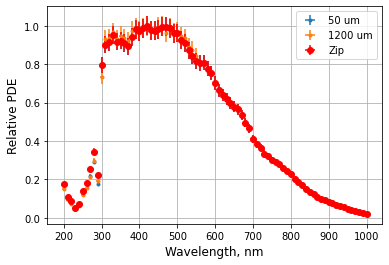

In [25]:
plt.errorbar(iv_data_50um.pde_relative.keys(), list(iv_data_50um.pde_relative.values()), fmt = '.', 
             yerr = list(iv_data_50um.pde_relative_err.values()), xerr = iv_data_50um.wl_err, label = '50 um')
plt.errorbar(iv_data_1200um.pde_relative.keys(), list(iv_data_1200um.pde_relative.values()), fmt = '.', 
             yerr = list(iv_data_1200um.pde_relative_err.values()), xerr = iv_data_1200um.wl_err, label = '1200 um')


plt.errorbar(list(iv_data_1200um.pde_ziped.keys()), list(iv_data_1200um.pde_ziped.values()), 
             xerr = list(iv_data_1200um.pde_ziped_wl_err.values()), 
             yerr = list(iv_data_1200um.pde_ziped_err.values()), fmt = 'ro', label = 'Zip')

plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("Relative PDE", fontsize=12)
plt.grid()
plt.legend()

## Normalize the PDE 

For this we need an absolute PDE, so we are using file with absolute PDE vs. Overvoltage fit at a given wavelength

In [26]:
df = pd.read_csv('./data_example/fit_pde_results.csv')
df.head()

wavelength (nm)  wavelength err. (nm)   PDE Max.  PDE Slop
0            385.1                   6.9  54.858439  0.598226
1            402.0                  11.7  65.558927  0.600204
2            450.7                  14.6  63.251696  0.628472
3            468.9                  18.3  58.378208  0.659345
4            504.8                  17.5  54.172231  0.627140

Now we can read fit parameters, and draw the absolute PDE vs. Overvoltage for some wavelengthes:

In [27]:
iv_data_1200um.get_absoluter_pde('./data_example/fit_pde_results.csv', overvoltage)

   wavelength (nm)  wavelength err. (nm)   PDE Max.  PDE Slop
0            385.1                   6.9  54.858439  0.598226
1            402.0                  11.7  65.558927  0.600204
2            450.7                  14.6  63.251696  0.628472
3            468.9                  18.3  58.378208  0.659345
4            504.8                  17.5  54.172231  0.627140
key :  385.1  pde :  53.343461070890726
key :  402.0  pde :  63.7698013436174
key :  450.7  pde :  61.79483028654759
key :  468.9  pde :  57.26095835264496
key :  504.8  pde :  52.91447908708543
key :  525.6  pde :  48.58194501710291
key :  600.0  pde :  42.70418082929359
key :  631.4  pde :  40.508099020640444
mean AC pde :  52.60971937597788
wavelengths   :  [402.0, 450.7, 468.9, 504.8, 525.6, 600.0, 631.4]
mean absolute :  52.60971937597788
mean relative :  0.8719442934057334
norm factor   :  60.336101484751055


Now knowing the normalization factor **iv_data_1200um.k_factor** we can calculate the absolute PDE vs. Wavelength:

Text(0, 0.5, 'PDE, %')

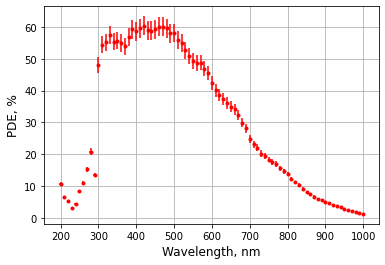

In [28]:
plt.errorbar(list(iv_data_1200um.pde_ziped.keys()), iv_data_1200um.k_factor*np.array(list(iv_data_1200um.pde_ziped.values())), 
             xerr = list(iv_data_1200um.pde_ziped_wl_err.values()), 
             yerr = iv_data_1200um.k_factor*np.array(list(iv_data_1200um.pde_ziped_err.values())),
             fmt = 'r.')
plt.grid()
plt.xlabel("Wavelength, nm", fontsize=12)
plt.ylabel("PDE, %", fontsize=12)